<h2 align=center> <b><u> Fine-Tuned BERT for Quora Insincere Questions Classification </u></b>
</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

### This notebook is based on Coursera Project "Fine Tune BERT for Text Classification with TensorFlow" Tutorial. Link to the Tutorial: https://www.coursera.org/projects/fine-tune-bert-tensorflow

The pretrained BERT model used in this project is [available on Kaggle](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2).

### 1. Check GPU Availability

In [1]:
!nvidia-smi

Wed Feb 28 15:37:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 2. Install TensorFlow and TensorFlow Model Garden

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.15.0


In [3]:
#!pip install -q tensorflow==2.3.0

In [4]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [5]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# We may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done


### 3. Download and Import the Quora Insincere Questions Dataset

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip",
                 compression = 'zip', low_memory = False)
df.shape

(1306122, 3)

In [8]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


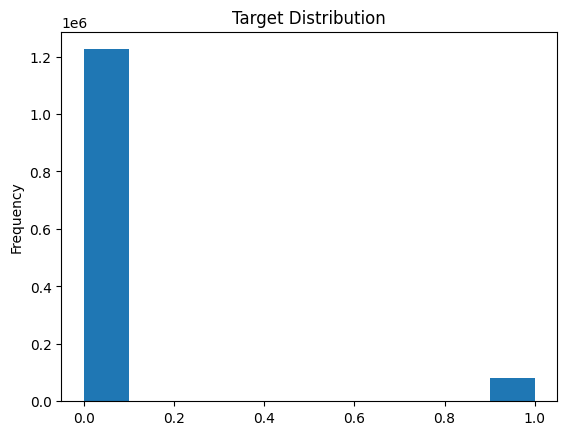

In [9]:
df.target.plot(kind='hist', title = 'Target Distribution');

### 4. Create tf.data.Datasets for Training and Evaluation

In [16]:
train_df, remaining = train_test_split(df, random_state = 42, train_size = 0.03, stratify = df.target.values)  #using only 3% of the original data
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = 0.003, stratify = remaining.target.values)
train_df.shape, valid_df.shape

((39183, 3), (3800, 3))

In [17]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

for text, label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'How can I beat slot machines?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


### 5. Download a Pre-trained BERT Model from TensorFlow Hub

In [18]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32



# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable = True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [19]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')             # Note the comma(,) is attached to the previous word "hi"
                                                                             # The tokeized form of (,) is hence '##,' where '##' signifies
                                                                             # it is attached to previous token

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [20]:
# Converting tokens to token_ids/ numbers to be fed to the BERT

tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

Note that this is not the whole story. We also have to make sure that each sequence is initiated with the CLS token (which signifies start of sequence and has a token_id 101) and ended with SEP (separator) which means end of sequence and has a token_id 102. Also we have to make sure that all tensors have sequence size equal to the max_sequence_length by using padding.

### 6. Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

**Token IDs** - This corresponds to the tokenized strings padded with 0s
                upto the max sequence length and beginning with CLS and ending with SEP. <br><br>
**Input Mask** - Note that BERT uses Self-Attention Networks to provide
                 contextualised embeddings corresponding to each token in the token string i.e., for each word in the string BERT looks to the left and right of it in the sentence so as to find contextual meaning of the word in the sentence (say, if there is a "the", then look at the noun to which it points). Now, note that we have padded our token strings with 0s upto the max seq length, but we do not want the padding 0s to influence the contextual information to be derived.  The Input Mask is a list of same length as the length of Token Ids (ie the max seq length) where there is a 0 for a padding and 1 for a valid token. The 0s will cancel out the internal multiplications that we perform for capturing the Self Attention for contextual information. <br><br>

**Input Type IDs** - Note that originally BERT was pretrained on two   tasks, Masked Language Modelling (where random words from the sentence would be masked and it would be the task for the BERT to predict what those masked words are) and the other task was Next Sentence Prediction or NSP (Given two sentences, the BERT has to predict which came first and which came after. The first sentence was given the value 0 and the next sentence was given the value 1).<br><br>
**In Text classification, we are dealing with only 1 sequence at a time, so our input type IDs would just be a vector with all values 0. **


In [21]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None, # 1 for NSP and None for text classification
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)   # we are converting the 0th example
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

  #returning the Token IDs, Input Masks, Input type IDs and Labels

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

### 7. Wrap a Python Function into a TensorFlow op for Eager Execution

In [22]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp = [text, label],
                                                                Tout = [tf.int32, tf.int32, tf.int32, tf.int32])  # stands for Tensor output type
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids': segment_ids
  }

  return [x, label_id]

### 8. Create a TensorFlow Input Pipeline with `tf.data`

In [23]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)    # The dataset mapping can be parallelised
                                                                                       # over the CPU cores available, but we do not know
                                                                                       #  how many CPU cores are available, so we let Tf find it out!

                .shuffle(1000).batch(32, drop_remainder=True)                          # If there are more samples left afterwards, drop them
                                                                                       # so that all batches are equal size

                .prefetch(tf.data.experimental.AUTOTUNE))                              # when model is training on nth batch, prefetch
                                                                                       # next batch of input to save time

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
                .batch(32, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE))

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [24]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [25]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

### 9. Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

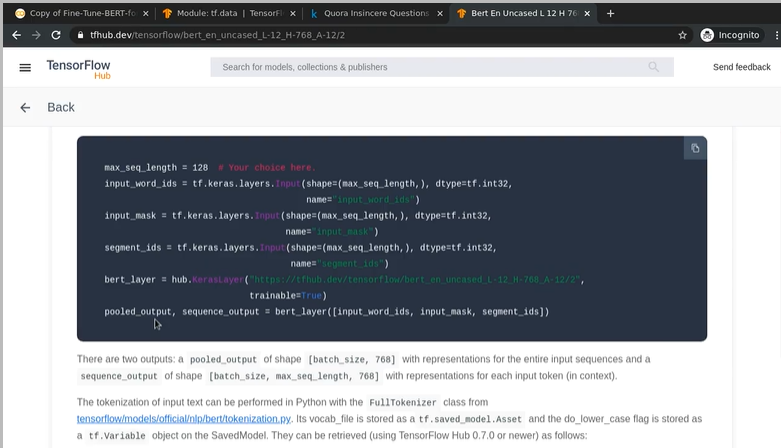

We only need the pooled_output that represents the whole sentence (using the CLS token that contains the contextual information of the whole sentence) and not the sequence_output.

In [29]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype = tf.int32, name = "input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length, ), dtype = tf.int32, name = "input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype = tf.int32, name = "input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  # Add dropout layer
  drop1 = tf.keras.layers.Dropout(0.2)(pooled_output)

  # Add hidden dense layers
  hidden1 = tf.keras.layers.Dense(128, activation='relu')(drop1)
  drop2 = tf.keras.layers.Dropout(0.2)(hidden1)
  hidden2 = tf.keras.layers.Dense(32, activation='relu')(drop2)
  drop3 = tf.keras.layers.Dropout(0.2)(hidden2)

  # Output layer
  output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop3)

  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output_layer
  )

  return model

### 10. Fine-Tune BERT for Text Classification

In [30]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

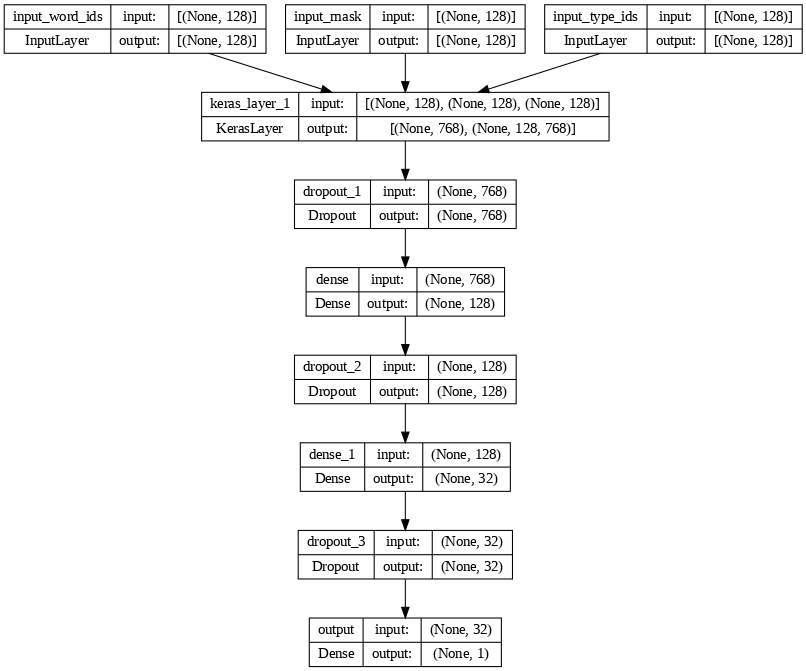

In [31]:
tf.keras.utils.plot_model(model = model, show_shapes=True, dpi=76)

In [32]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
1224/1224 [==============================] - 1053s 822ms/step - loss: 0.1437 - binary_accuracy: 0.9452 - val_loss: 0.1069 - val_binary_accuracy: 0.9566
Epoch 2/4
1224/1224 [==============================] - 1008s 823ms/step - loss: 0.0886 - binary_accuracy: 0.9664 - val_loss: 0.1306 - val_binary_accuracy: 0.9574
Epoch 3/4
1224/1224 [==============================] - 999s 816ms/step - loss: 0.0542 - binary_accuracy: 0.9808 - val_loss: 0.1502 - val_binary_accuracy: 0.9603
Epoch 4/4
1224/1224 [==============================] - 999s 816ms/step - loss: 0.0312 - binary_accuracy: 0.9891 - val_loss: 0.1646 - val_binary_accuracy: 0.9579


### 11. Evaluate the BERT Text Classification Model

In [33]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

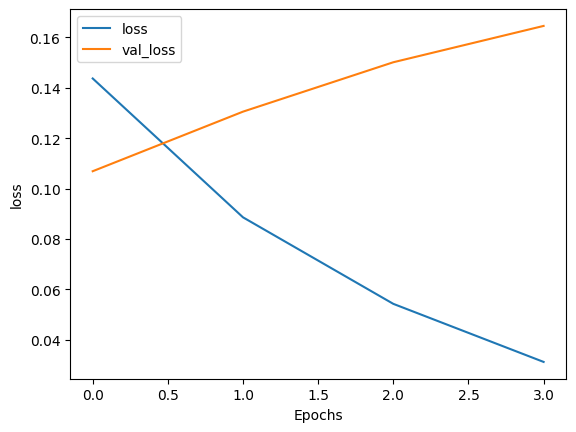

In [34]:
plot_graphs(history, 'loss')

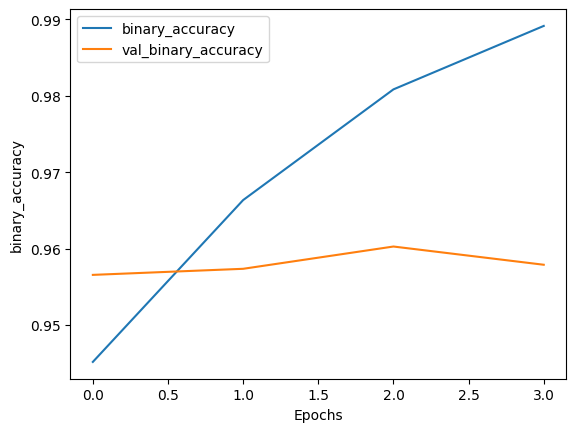

In [35]:
plot_graphs(history, 'binary_accuracy')

In [36]:
sample_example = ["why are americans racist?", "why are indians so black?", "have a great day!"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))   #passing a vector of 0s in place of the target vector
                                                                                            #the model will anyways not do anything to this vector
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.5 #between 0 and 1


["Insincere" if pred>=threshold else "Sincere" for pred in preds]

3/3 [==============================] - 1s 23ms/step


['Insincere', 'Insincere', 'Sincere']

### 12. Saving the model

In [39]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save the trained model to Google Drive
model.save('/content/drive/My Drive/bert_model.h5')

Mounted at /content/drive
